# Essentially, testing out my pipeline

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, pickle
import numpy as np
import matplotlib.pyplot as plt
from cv2 import SIFT_create, imread, cvtColor, COLOR_BGR2GRAY, GaussianBlur
from skimage.io import imread

from scripts.utils import extract_frames_info
from scripts.display_utils import show_image_with_bbs
from scripts.hog.classifier import HOGClassifier


In [3]:
frames_info = extract_frames_info("data/train.csv")

In [16]:
classifier = HOGClassifier()

features, labels = classifier.features_labels(frames_info[:10], 1)

100%|██████████| 10/10 [00:00<00:00, 10010.27it/s]


In [19]:
features[1].shape

(34560,)

In [4]:
with open("models/hog/ultra_neg_64_8.pkl", "rb") as pickle_file:
    classifier = pickle.load(pickle_file)

C:\Users\Baptiste Prevot\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LinearSVC from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[1]


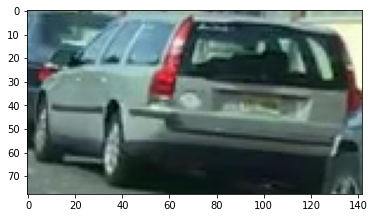

In [5]:
image_index = 100
image = imread(frames_info[image_index][0])

car_index = 5

car_bb = frames_info[image_index][1][car_index]
car_image = image[car_bb[1]: car_bb[1]+car_bb[3], car_bb[0]: car_bb[0]+car_bb[2]]
plt.imshow(car_image)
print(classifier.predict(car_image))

[1]


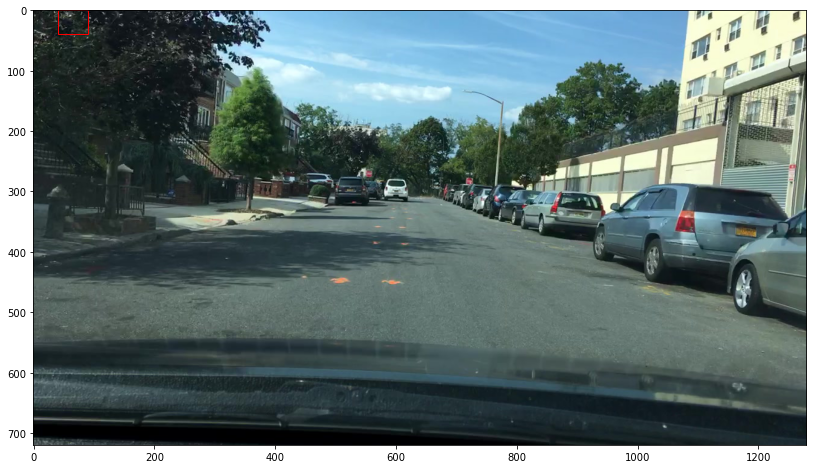

In [66]:
image_index = 100
image = imread(frames_info[image_index][0])

car_bb = [500, 250, 150, 100]
car_image = image[car_bb[1]: car_bb[1]+car_bb[3], car_bb[0]: car_bb[0]+car_bb[2]]
print(classifier.predict(car_image))
show_image_with_bbs(frames_info[image_index][0], [car_bb])

## Testing detection

In [6]:
from scripts.hog.detector import Detector
import pickle
from skimage.io import imread
from scripts.display_utils import show_image_with_bbs

In [7]:
detector = Detector(classifier)

In [8]:
image_index = 2000
image = imread(frames_info[image_index][0])

detections = detector.detect(image, 10, [64, 128, 256, 400], [.8, 0.5, 1.0])

100%|██████████| 12/12 [10:18<00:00, 51.53s/it]


In [9]:
print(len(detections))
detections = detector.nms(detections, .5)

304


69


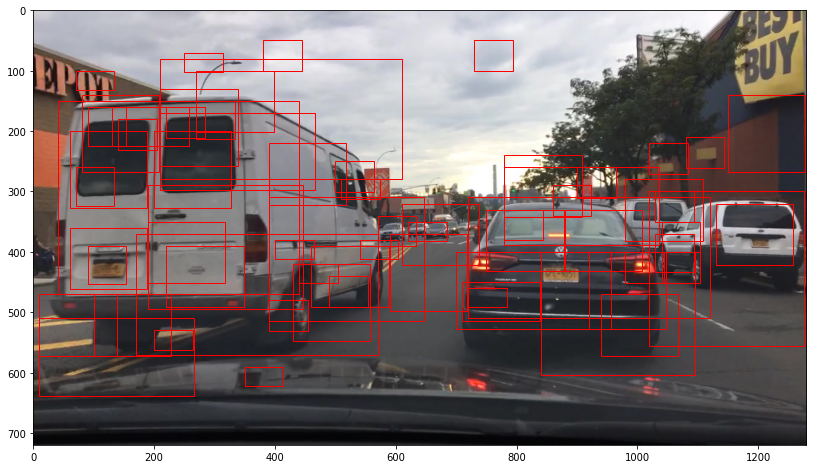

In [10]:
print(len(detections))

show_image_with_bbs(frames_info[image_index][0], detections)


## Hard example mining

In [27]:
from scripts.hog.bounding_box_utils import find_free_window
from random import choice
from tqdm.auto import tqdm

In [25]:
WINDOW_WIDTHS, WINDOW_RATIOS = [64, 128, 256, 400], [.8, 0.5, 1.0]

WINDOW_SHAPES = [(width, int(width*ratio)) for width in WINDOW_WIDTHS for ratio in WINDOW_RATIOS]
def mine_hard_example(image_path, bboxes, n_examples, classifier):
    pbar = tqdm()
    examples = []
    image = imread(image_path)
    while len(examples) < n_examples:
        window = find_free_window((image.shape[1], image.shape[0]), bboxes, choice(WINDOW_SHAPES))
        if window is None:
            continue
        sub_image = image[window[1]: window[1]+window[3], window[0]: window[0]+window[2]]
        label, feature_vect = classifier.predict(sub_image, True)
        if label:
            examples.append(feature_vect)
            pbar.update()
    pbar.close()
    return examples

In [28]:
car_index = 0
image_path, bboxes = frames_info[car_index]

hard_examples = mine_hard_example(image_path, bboxes, 20, classifier)
print(len(hard_examples))

20it [05:19, 15.98s/it]

20


## Misc

In [ ]:
bounding_boxes = [[0, 0, 5, 5], [5, 5, 5, 5]]

For simplicity, let's say they are the same for all test images (yours won't be). Then, we can create a Kaggle submission file like this:

In [ ]:
test_files = sorted(os.listdir('./test/'))

rows = []

for file_name in test_files:

    rle = run_length_encoding(bounding_boxes_to_mask(bounding_boxes, H, W))
    rows.append(['test/' + file_name, rle])

df_prediction = pd.DataFrame(columns=['Id', 'Predicted'], data=rows).set_index('Id')
df_prediction.to_csv('sample_submission.csv')